# About this notebook

[updated 20241025] from this [topic](https://www.kaggle.com/competitions/jane-street-real-time-market-data-forecasting/discussion/542022#3026354), I remake this simulator using the evaluation API directly. But, not change the how to use this.

------------- --

I created a simulator based on my explanation(https://www.kaggle.com/code/chumajin/janestreet-easy-to-understand-new-time-series-api) of how the time API works.
You can check your memory and time is enough or not in this notebook.

## how to use

### Step 1 : change valid_from in # 1

from this discussion, I estimated the period of the public and private data_id.
https://www.kaggle.com/competitions/jane-street-real-time-market-data-forecasting/discussion/541314#3021981

For public test : you should set this 1577 (This means 6 months).
For private test : you should set this 1455 (This means 1 year).

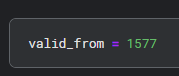

### Step 2 : change predict function in # 3

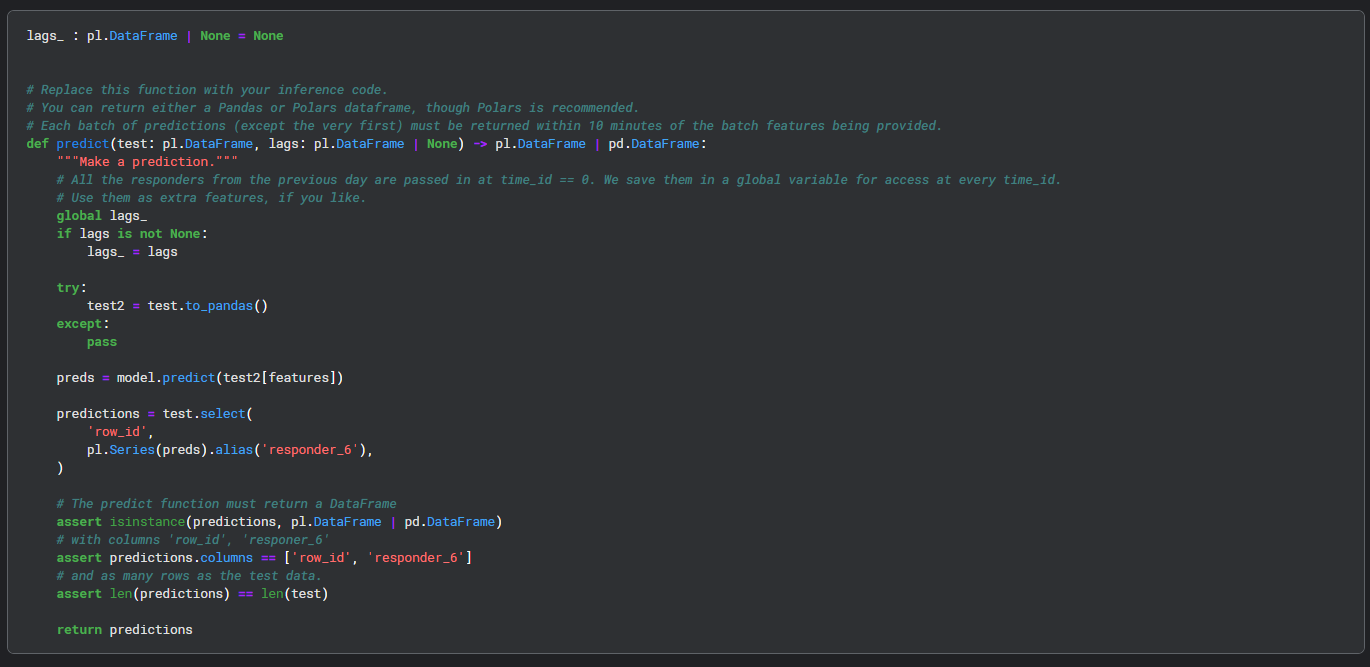


This code is a sample of my lightGBM result.

However, since this is a simulator, it does not provide any guarantees. Please use it carefully and enjoy!

# 0. import

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import polars as pl
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import lightgbm
import torch

# 1. make valid data

Note that : you should change this from public test 1577(6 months) to 1455 for private tests(1 year) when you check for private tests.

Please pay attention to Out of memory if you want to set for longer period.

In [5]:
valid_from = 1577 # for private you should change to 1455 (1 year)

In [6]:
alltraindata = pl.scan_parquet("/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet")
valid_df = alltraindata.filter(pl.col("date_id")>=valid_from).collect()

In [7]:
valid_df = valid_df.with_columns(pl.Series(range(len(valid_df))).alias("row_id"),
                                pl.lit(True).alias("is_scored"))
len(valid_df)

4532176

In [8]:
valid_df.write_parquet("valid_df.parquet")

In [9]:
test_sample = pl.read_parquet("/kaggle/input/jane-street-real-time-market-data-forecasting/test.parquet/date_id=0/part-0.parquet")
test_sample.head(3)

row_id,date_id,time_id,symbol_id,weight,is_scored,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,…,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78
i64,i16,i16,i8,f32,bool,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,0,0,0,3.169998,true,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,null,-0.0,null,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,…,null,-0.0,null,-0.0,0.0,-0.0,0.0,0.0,null,0.0,null,null,-0.0,null,-0.0,0.0,null,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,null,null,0.0,0.0,-0.0,-0.0
1,0,0,1,2.165993,true,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,null,-0.0,null,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,…,null,-0.0,null,-0.0,0.0,0.0,0.0,0.0,null,0.0,null,null,-0.0,null,-0.0,0.0,null,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,null,null,0.0,0.0,0.0,0.0
2,0,0,2,3.06555,true,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,null,-0.0,null,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,…,null,-0.0,null,-0.0,0.0,-0.0,-0.0,-0.0,null,0.0,null,null,-0.0,null,-0.0,0.0,null,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,null,null,0.0,0.0,-0.0,-0.0


In [10]:
valid_df = valid_df.select(test_sample.columns)

In [11]:
valid_df.head(3)

row_id,date_id,time_id,symbol_id,weight,is_scored,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,…,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78
i64,i16,i16,i8,f32,bool,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,1577,0,0,3.083925,true,3.366654,1.360199,3.079305,3.362146,3.6144,-0.801272,0.417092,0.600738,1.205706,11,7,76,-1.188979,4.094112,0.185692,null,-0.28196,null,-1.23995,-1.287588,-0.370484,-0.021203,1.780404,0.682673,2.174914,0.555538,0.576046,0.585217,-0.005107,-0.463267,-0.46577,…,null,-0.424941,null,-1.348726,1.278842,-1.0642,0.422928,0.186234,null,0.485685,null,null,-0.604928,null,-1.9968,1.475937,null,0.311525,0.15181,-0.064444,0.064936,-0.271633,-0.281038,-1.864882,-1.802427,-0.744756,3.664253,0.362792,-0.995463,1.589817,-0.196484,null,null,1.842304,0.996843,0.988779,0.787753
1,1577,0,1,2.749173,true,2.790219,1.520227,3.400155,3.013683,3.240175,-1.314916,0.516105,0.538317,0.706976,11,7,76,-0.793896,4.044909,0.506718,null,-0.616078,null,-1.871069,-2.133816,-0.444158,0.27347,0.523213,0.322614,1.749547,0.620865,-1.516594,-0.569187,0.346665,-0.709288,-0.973437,…,null,-0.272775,null,-0.800755,1.567405,-1.218263,0.678287,0.248421,null,1.232812,null,null,0.610962,null,-1.636767,1.746855,null,0.875238,0.517489,-0.064444,0.997516,-0.401954,0.02799,-1.882409,-1.552617,-0.389351,6.10117,0.757686,-0.715378,1.679968,-0.057424,null,null,2.016665,1.423909,0.195099,0.128859
2,1577,0,2,3.042504,true,3.767164,1.915177,2.813827,2.929534,2.975633,-0.669956,0.604368,0.587685,0.981845,81,2,59,-0.761609,1.025871,-0.019335,null,-0.547273,null,-1.668278,-1.47858,-0.075131,-0.097833,0.231002,0.047338,1.279958,0.333603,0.617355,0.184616,-0.331382,-0.547517,-0.754573,…,null,0.236657,null,-0.754802,1.858293,-1.007362,3.398412,2.24463,null,1.467049,null,null,-0.432542,null,-1.486082,2.246191,null,1.545955,0.679034,-0.064444,0.020095,-0.27814,-0.311834,-2.140895,-1.011106,-0.655783,2.538372,0.155616,-1.167594,1.220114,-0.203679,null,null,2.879083,3.538342,0.328459,0.462452


# 2. make lag function

In [12]:
lag_sample = pl.read_parquet("/kaggle/input/jane-street-real-time-market-data-forecasting/lags.parquet/date_id=0/part-0.parquet")
train_sample = pl.read_parquet("/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=0/part-0.parquet",n_rows=1)
responder_cols = [s for s in train_sample.columns if "responder" in s]

def makelag(date_id):
    """
    Making lag at the previout day

    Args:
    date_id (int): date_id at the previout day
    
    Returns:
    pl.dataframe
    """
    
    lag = alltraindata.filter(pl.col("date_id")==date_id).select(["date_id","time_id","symbol_id"] + responder_cols).collect()
    lag.columns = lag_sample.columns
    
    return lag    

# 3. make the test and lag data for debug

In [13]:
os.makedirs("./debug/test.parquet",exist_ok=True)
os.makedirs("./debug/lags.parquet",exist_ok=True)

In [14]:
total_iterations = len(valid_df["date_id"].unique())
total_iterations

122

In [15]:
for num_days, df_per_day in tqdm(valid_df.group_by("date_id",maintain_order=True),total=total_iterations,desc="Processing"):
    
       
    day = num_days[0] - valid_from # date_id must start from 0.
    
    os.makedirs(f"./debug/test.parquet/date_id={day}",exist_ok=True)
    os.makedirs(f"./debug/lags.parquet/date_id={day}",exist_ok=True)
    
    lag = makelag(num_days[0] - 1)
    
    df_per_day.write_parquet(f"./debug/test.parquet/date_id={day}/part-0.parquet")
    lag.write_parquet(f"./debug/lags.parquet/date_id={day}/part-0.parquet")

Processing: 100%|██████████| 122/122 [00:14<00:00,  8.69it/s]


# 4. predict of your function : change here to yours

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import statistics as stat
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import copy
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.optim as optim
import copy
import polars as pl
class LSTM(nn.Module):
    def __init__(self,
                 num_features: int,
                 hidden_size: int = 128,
                 num_layers: int = 1,
                 output_size: int = 1,
                 dropout_rate: float = 0.5):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.expand = nn.Sequential(
            nn.LayerNorm(num_features),
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, hidden_size),
            nn.ReLU()
        )

        # Convolutional layers with corrected in_channels
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=self.hidden_size // 16, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0
        )

        # Fully connected layer
        self.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, output_size),
            nn.Tanh()
        )

    def forward(self, x):
        # x shape: (batch_size, num_features)
        x = self.expand(x)
        batch_size = x.size(0)
        seq_length = x.size(1) // (self.hidden_size // 16)
        x = x.view(batch_size, self.hidden_size // 16, seq_length)

        x = self.conv1(x)
        x = self.conv2(x)
        
        # Prepare for LSTM
        x = x.permute(0, 2, 1)  # (batch_size, seq_length, features)
        
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        self.lstm.flatten_parameters()

        # LSTM layer
        out, _ = self.lstm(x, (h0, c0))

        # Output layer
        out = self.fc(out[:, -1, :])
        return out.squeeze()

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTM(num_features=79, hidden_size=512, output_size = 1, num_layers = 1).to(device)
model.load_state_dict(
    torch.load(
        "/kaggle/input/js-cnn-lstm/exported_cnn_lstm_12.pth", 
        map_location=device,
        weights_only=True
    )
)

<All keys matched successfully>

In [29]:
features = [s for s in valid_df.columns if "feature" in s]
len(features)

79

In [30]:
means = {'feature_00': 0.640198826789856, 'feature_01': 0.03755598142743111, 'feature_02': 0.6368075609207153, 'feature_03': 0.6365063786506653, 'feature_04': 0.013741530478000641, 'feature_05': -0.02173694409430027, 'feature_06': -0.006415014620870352, 'feature_07': -0.010971736162900925, 'feature_08': -0.04653771221637726, 'feature_09': 32.596106194690265, 'feature_10': 4.95929203539823, 'feature_11': 167.6541592920354, 'feature_12': -0.13415881991386414, 'feature_13': -0.07573335617780685, 'feature_14': -0.12015637010335922, 'feature_15': -0.7470195889472961, 'feature_16': -0.6257441639900208, 'feature_17': -0.7294047474861145, 'feature_18': -0.042215555906295776, 'feature_19': -0.08798160403966904, 'feature_20': -0.15741558372974396, 'feature_21': 0.10528526455163956, 'feature_22': 0.018054703250527382, 'feature_23': 0.03165541961789131, 'feature_24': 2.733017921447754, 'feature_25': 0.39958420395851135, 'feature_26': -0.11045943945646286, 'feature_27': -0.5332594513893127, 'feature_28': -0.4522790312767029, 'feature_29': -0.5739678144454956, 'feature_30': -0.7905704975128174, 'feature_31': 0.10600688308477402, 'feature_32': 0.40044134855270386, 'feature_33': -0.021725023165345192, 'feature_34': 0.4226262867450714, 'feature_35': 0.42143046855926514, 'feature_36': -0.00023802756913937628, 'feature_37': 0.027961043640971184, 'feature_38': 0.010258913040161133, 'feature_39': 0.005768273025751114, 'feature_40': 0.017485467717051506, 'feature_41': 0.038347117602825165, 'feature_42': -0.06123563274741173, 'feature_43': -0.11644423753023148, 'feature_44': -0.12342483550310135, 'feature_45': -0.028769943863153458, 'feature_46': -0.015200662426650524, 'feature_47': 0.015717582777142525, 'feature_48': -0.0033910537604242563, 'feature_49': -0.0052393232472240925, 'feature_50': -0.2285808026790619, 'feature_51': -0.3548349440097809, 'feature_52': -0.358092725276947, 'feature_53': 0.2607136368751526, 'feature_54': 0.18796788156032562, 'feature_55': 0.3154229521751404, 'feature_56': -0.1471923440694809, 'feature_57': 0.15730056166648865, 'feature_58': -0.021774644032120705, 'feature_59': -0.0037768862675875425, 'feature_60': -0.010220836848020554, 'feature_61': -0.03178725391626358, 'feature_62': -0.3769100308418274, 'feature_63': -0.3229374587535858, 'feature_64': -0.3718394339084625, 'feature_65': -0.10233989357948303, 'feature_66': -0.13688170909881592, 'feature_67': -0.14402112364768982, 'feature_68': -0.06875362992286682, 'feature_69': -0.11862917989492416, 'feature_70': -0.11789549142122269, 'feature_71': -0.06013699993491173, 'feature_72': -0.10766122490167618, 'feature_73': -0.09921672940254211, 'feature_74': -0.10233042389154434, 'feature_75': -0.05991339311003685, 'feature_76': -0.06349952518939972, 'feature_77': -0.07424316555261612, 'feature_78': -0.07759837061166763}
stds = {'feature_00': 1.027751088142395, 'feature_01': 1.0967519283294678, 'feature_02': 1.0156300067901611, 'feature_03': 1.0170334577560425, 'feature_04': 1.0726385116577148, 'feature_05': 0.9639211297035217, 'feature_06': 1.0963259935379028, 'feature_07': 1.0789952278137207, 'feature_08': 0.7962697148323059, 'feature_09': 23.72976726545254, 'feature_10': 3.1867162933797224, 'feature_11': 163.44513161352285, 'feature_12': 0.6700984835624695, 'feature_13': 0.5805172920227051, 'feature_14': 0.664044201374054, 'feature_15': 0.37517768144607544, 'feature_16': 0.3393096327781677, 'feature_17': 0.3603287935256958, 'feature_18': 0.9911752939224243, 'feature_19': 1.0550744533538818, 'feature_20': 0.6643751263618469, 'feature_21': 0.38239365816116333, 'feature_22': 0.950261116027832, 'feature_23': 0.8119344711303711, 'feature_24': 1.4362775087356567, 'feature_25': 1.0947270393371582, 'feature_26': 1.077124834060669, 'feature_27': 1.0645726919174194, 'feature_28': 1.0676648616790771, 'feature_29': 0.2640742361545563, 'feature_30': 0.19689509272575378, 'feature_31': 0.3815343976020813, 'feature_32': 1.2996565103530884, 'feature_33': 0.9989405870437622, 'feature_34': 1.3409572839736938, 'feature_35': 1.3365675210952759, 'feature_36': 0.8695492148399353, 'feature_37': 0.7334080934524536, 'feature_38': 0.698810338973999, 'feature_39': 0.7965824604034424, 'feature_40': 0.518515944480896, 'feature_41': 0.6384949088096619, 'feature_42': 0.8168442249298096, 'feature_43': 0.5228385925292969, 'feature_44': 0.6521403193473816, 'feature_45': 0.8666537404060364, 'feature_46': 0.9039222002029419, 'feature_47': 3.2711963653564453, 'feature_48': 0.6570901274681091, 'feature_49': 0.7083076238632202, 'feature_50': 1.0132617950439453, 'feature_51': 0.6081287860870361, 'feature_52': 0.9250587224960327, 'feature_53': 1.0421689748764038, 'feature_54': 0.5859629511833191, 'feature_55': 0.9191848039627075, 'feature_56': 0.9549097418785095, 'feature_57': 1.0204777717590332, 'feature_58': 0.8327276110649109, 'feature_59': 0.8309783339500427, 'feature_60': 0.8389413356781006, 'feature_61': 1.192766547203064, 'feature_62': 1.388945460319519, 'feature_63': 0.09957146644592285, 'feature_64': 0.3396177291870117, 'feature_65': 1.01683509349823, 'feature_66': 1.0824761390686035, 'feature_67': 0.642227828502655, 'feature_68': 0.5312599539756775, 'feature_69': 0.6208390593528748, 'feature_70': 0.6724499464035034, 'feature_71': 0.5356909036636353, 'feature_72': 0.6534596681594849, 'feature_73': 1.0855497121810913, 'feature_74': 1.0880277156829834, 'feature_75': 1.2321789264678955, 'feature_76': 1.2345560789108276, 'feature_77': 1.0921478271484375, 'feature_78': 1.0924347639083862}
def normalize_dataframe(df: pl.DataFrame, means: dict, stds: dict) -> pl.DataFrame:
    """
    Normalize a Polars DataFrame using the provided means and standard deviations.

    Args:
    df (pl.DataFrame): The input DataFrame to normalize
    means (dict): A dictionary of column means
    stds (dict): A dictionary of column standard deviations

    Returns:
    pl.DataFrame: The normalized DataFrame
    """

    # Create a list to store our normalization expressions
    normalize_exprs = []

    for col in df.columns:
        if col in means and col in stds:
            # Ensure we don't divide by zero
            if stds[col] != 0:
                normalize_exprs.append(
                    ((pl.col(col) - means[col]) / stds[col]).alias(col)
                )
            else:
                # If std is 0, just subtract the mean
                normalize_exprs.append(
                    (pl.col(col) - means[col]).alias(col)
                )
        else:
            # If we don't have mean/std for this column, leave it as is
            normalize_exprs.append(pl.col(col))

    # Apply the normalization to the dataframe
    normalized_df = df.select(normalize_exprs)

    return normalized_df
    
def predict(test: pl.DataFrame, lags: pl.DataFrame | None) -> pl.DataFrame | pd.DataFrame:
    """Make a prediction."""
    global model
    global device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Load the model if it's not already loaded
    model.load_state_dict(
        torch.load(
            "/kaggle/input/js-cnn-lstm/exported_cnn_lstm_12.pth", 
            map_location=device,
            weights_only=True
        )
    )
    model.eval()  # Set the model to evaluation mode
    sel_cols  = [f"feature_{i:02d}" for i in range(79)]

    # Process the test data using Polars
    # Select the same features used during training


    # Ensure all required columns are present
    missing_cols = set(sel_cols) - set(test.columns)
    if missing_cols:
        raise ValueError(f"Missing columns in test data: {missing_cols}")

    # Select the features
    test_features = test.select(sel_cols)

    # **Apply forward fill and then fill remaining missing values with zero**
    test_features = test_features.fill_null(strategy='forward').fill_null(0)
    test_features = normalize_dataframe(test_features,means,stds)

    # Convert Polars DataFrame to NumPy array
    X_test = test_features.to_numpy()

    # Convert to Torch tensor
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

    # Make predictions
    with torch.no_grad():
        
        outputs = model(X_test_tensor)
        # Assuming the model outputs a tensor of shape (batch_size, 1)
        predictions = outputs.squeeze().cpu().numpy()

    # Prepare the predictions DataFrame
    predictions_df = pl.DataFrame({
        'row_id': test['row_id'],
        'responder_6': predictions
    })

    # The predict function must return a DataFrame
    assert isinstance(predictions_df, (pl.DataFrame, pd.DataFrame))
    # with columns 'row_id', 'responder_6'
    assert predictions_df.columns == ['row_id', 'responder_6']
    # and as many rows as the test data.
    assert len(predictions_df) == len(test)

    return predictions_df

# 5. check submission using the evalution API

In [31]:
import kaggle_evaluation.jane_street_inference_server

Note that : this takes a lot of time because this is the estimated submission time

My LGBM result : real submission time 32 min, this evaluation API simulator : about 23-24 min so far

In [ ]:
%%time

inference_server = kaggle_evaluation.jane_street_inference_server.JSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            './debug/test.parquet',
            './debug/lags.parquet',
        )
    )